# Learn about models and do parameter estimation in a notebook #

A `model` in pycbc inference represents the problem you are trying to solve. It contains the definition of the likelihood function you want to explore and details the parameters you are using. In this tutorial, we'll walk through using models with pycbc inference and see how to create your own. 

Note that it's best to go through this tutorial in order as some sections may rely on earlier ones. 

* [1. One-dimensional Analytic Model](#1.-One-dimensional-Analytic-Model)
* [2. Higher Dimensions](#2.-Higher-Dimensions)
* [3. Make your own simple model](#3.-Make-your-own-model)
* [4. Model that uses data](#4.-Making-a-model-that-uses-data)
* [5. Model with priors](#5.-Using-a-model-with-priors)
* [6. Measure the distance to GW170817](#6.-Estimating-the-distance-of-GW170817)
* [7. Estimate the sky location of GW170817](#7.-Estimating-the-sky-location-of-GW170817)
* [8. Estimate the chirp mass of GW170817](#8.-Estimating-the-chirp-mass-of-GW170817)

### Make sure the software is set up ###


In [1]:

import sys
!{sys.executable} -m pip install pycbc ligo-common emcee==2.2.1 --no-cache-dir

DEPRECATION: Python 2.7 will reach the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 won't be maintained after that date. A future version of pip will drop support for Python 2.7. More details about Python 2 support in pip, can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support
You should consider upgrading via the 'pip install --upgrade pip' command.


## 1. One-dimensional Analytic Model ##

The simplest case is a problem with a single parameter. We'll go through how to estimate this parameter using an analytic model. In this case, we'll use the normal distribution.

Create an instance of a pre-made Model. This is an analytic model (i.e. no data used)
that we employ largely for testing the capabilities of different samplers. 
This will create a likelihood surface in one dimensions (x) with zero mean and unit variance

In [1]:
from pycbc.inference import models
from pycbc.distributions import Uniform

my_model = models.TestNormal(('x'), mean=(0))

We need to choose a sampler, in this case *emcee*. We need to provide the model we are
using along with the prior and number of walkers. Emcee is an 'ensemble' sampler so
it consists of many points which are traversing the space and help each other
explore the likelihood surface.

In [2]:
from pycbc.inference import sampler

engine = sampler.EmceeEnsembleSampler(my_model, nwalkers=1000, nprocesses=8)

Before we start we need to decide the initial positions of the walkers
In this case we choose that they be distributed randomly between -1 and 1. We use the 'Uniform' distribution class. It is a common feature that these classes take the parameter name along with parameters that may define the distribution itself (such as bounds and other distribution-specific shape determining variables).

In [3]:
_ = engine.set_p0(prior=(Uniform(x=(-1, 1))))

Run the mcmc for 200 iterations

In [4]:
engine.run_mcmc(200)

We can get the entire history of where the "walkers" have been by looking at the samples
attribute. For each variable parameter, we get an array with 
dimensions nwalkers x num_iterations. This is the format for the 'Emcee' sampler. Other samples may have other formats for their parameter chains. For example, parallel tempered samplers will have an additional dimension which represents the temperature. 

In [5]:
import pylab, numpy

xchain = engine.samples['x']

The chain has 2 dimensions, the first axis is the walker
and the second is the iteration.
We'll plot the final position of each walker

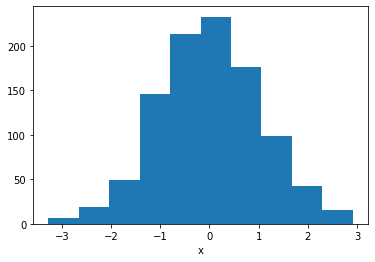

0.001991651750180072 1.059056802019295


In [6]:
values = xchain[:,-1]  
pylab.hist(values)
pylab.xlabel('x')
pylab.show()
print(values.mean(), numpy.var(values))

###  Suggested Problem ###

Try changing the mean of the analytic distribution. We've provided a random number below (no peaking!) What do you estimate for the mean of the distribution? 

In [7]:
from numpy.random import uniform, seed
seed(0)
a_number = uniform(-100, 100)

## 2. Higher Dimensions ##

We'll extend the previous example to higher dimensions.

The normal distribution analytic model is already set up to handle
many extra dimensions. We just need to name them.

In [8]:
from pycbc.inference import models
from pycbc.distributions import Uniform

my_model = models.TestNormal(('x', 'y'), mean=(0, 2))

In [9]:
from pycbc.inference import sampler

engine = sampler.EmceeEnsembleSampler(my_model, nwalkers=1000, nprocesses=8)

Notice how the following differs from before. We are setting a uniform distribution
for each parameter. This is used to set the intitial position
of the walkers.

In [10]:
pos = Uniform(
        x=(-1, 1),
        y=(-1, 1),
       )
engine.set_p0(prior=pos)

# Run the mcmc for 200 iterations
engine.run_mcmc(200)

0.04110547316260785 0.9644073345559433
2.0157441701698096 1.0285096384276409


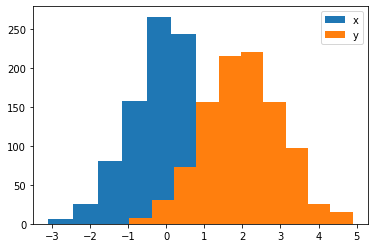

In [11]:
import pylab, numpy

# When we have multiple parameters, we can just access each by name as
# samples is a dictionary.

for param in ['x', 'y']:
    values = engine.samples[param][:,-1]
    pylab.hist(values, label=param)
    pylab.legend()
    print(values.mean(), numpy.var(values))

###  Suggested Problems ###

1. Try changing the number of dimensions of the normal distribution and find the distribution of each. 
2. Try out one of the other analytic distributions that pycbc inference provides. For example, try `models.TestVolcano`. (Note this model uses *exactly* two parameters which you choose a name for and takes no other configuration). If you are familiar with matplotlib, you can try making a 2d plot of the results. 

## 3. Making a Simple Model ##

So far we have gone through the mechanics of using an existing simple model. Let's now make our own analytic model. Each model inherits from [BaseModel](https://pycbc.org/pycbc/latest/html/pycbc.inference.models.html#module-pycbc.inference.models.base). We can make our own custom Model by inheriting from this class. We are required to define a single method (`_loglikelihood`). Other methods are provided by the base class, which we'll encounter as we go along.

To start off with, we'll create a simple model with a 
single parameter. We'll use the normal distribution.

In [12]:
from pycbc.inference.models.base import BaseModel
from scipy.stats import norm

class ExampleModel(BaseModel):
    def __init__(self, param_name, **kwargs):
        # Initialize the base model. It needs to know what the
        # variable parameters are, given here as (param_name).
        super(ExampleModel, self).__init__((param_name), **kwargs)   
        self.param = param_name
    
    def _loglikelihood(self):
        # self.current_params is a dictionary of the parameters 
        # we need to evaluate the log(likelihood) for. The name
        # of the parameters are the ones we gave to the BaseModel init
        # method in the 'super' command above.
        pos = self.current_params[self.param]
        
        #We'll use the logpdf of the normal distribution from scipy
        return norm.logpdf(pos)
    
my_model = ExampleModel('x')

We can now setup the sampler, the initial positions of our walkers, and run for 200 iterations.

In [13]:
from pycbc.inference import sampler

engine = sampler.EmceeEnsembleSampler(my_model, nwalkers=1000, nprocesses=8)
engine.set_p0(prior=Uniform(x=(-1, 1)))
engine.run_mcmc(200)

Since our model is a simple version of the TestNormal analytic model we should find similar results. 

0.02425466043974442 0.9956161274842411


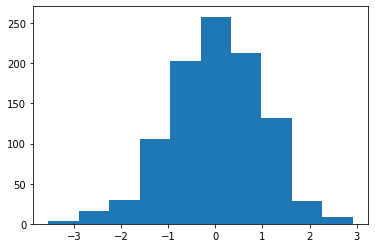

In [14]:
import pylab, numpy

xchain = engine.samples['x']
values = xchain[:,-1]  
pylab.hist(values)
print(values.mean(), numpy.var(values))

###  Suggested Problem ###

Replace the analytic PDF in our example model with one of your choosing and see if the ensemble mcmc can recover the distribution.

## 4. Making a model that uses data ##

Let's now see how we can pass data to a model. We'll have samples which  are drawn from an unkown normal distribution and try to estimate the distribution parameters (i.e. the mean and standard deviation). This model will contain two parameters, but for simplicity we fill the parameter names in the model as seen below. 

In [15]:
from pycbc.inference.models.base import BaseModel
from scipy.stats import norm
import numpy

class ExampleModel(BaseModel):
    def __init__(self, data, **kwargs):
        # We'll used fixed param names
        params = ('sigma', 'mean')
        
        super(ExampleModel, self).__init__(params, **kwargs)
        self.data = data
    
    def _loglikelihood(self):
        # self.current_params is a dictionary of the parameters 
        # we need to evaluate the log(likelihood) for.
        sigmasq = self.current_params['sigma'] ** 2.0
        mean = self.current_params['mean']
        n = len(self.data)
        
        # log likihood for a normal distribution
        loglk = -n / 2.0 * numpy.log(2 * numpy.pi * sigmasq)
        loglk += - 1. / (2 * sigmasq) * ((self.data - mean)**2.0).sum()
        return loglk

# Create some synthetic data
numpy.random.seed(10)
data = norm.rvs(size=10000)
my_model = ExampleModel(data)

Note that the likelihood we use above can be extended to apply to signal models where we expect
the residual noise to be Gaussian. Simply replace 'mean' with the model prediction
and set sigma to one if the problem is normalized. This is closely related to the
likelihood we in fact use for gravitational-wave data analysis.

In [16]:
from pycbc.inference import sampler

engine = sampler.EmceeEnsembleSampler(my_model, nwalkers=100, nprocesses=8)
pos = Uniform(sigma=(.5, 2),
              mean=(-1, 1)
             )
engine.set_p0(prior=pos)
engine.run_mcmc(400)

We can now view our estimates of the 'mean' and 'sigma'. 

Text(0.5, 1.0, 'mean')

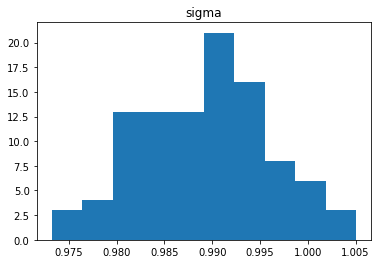

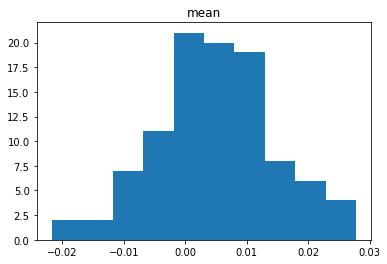

In [17]:
import pylab, numpy

xchain = engine.samples['sigma']
values = xchain[:,-1]  

pylab.figure()
pylab.title('sigma')
pylab.hist(engine.samples['sigma'][:,-1])

pylab.figure()
pylab.hist(engine.samples['mean'][:,-1])
pylab.title('mean')

## 5. Using a model with priors ##

We'll extend the last example by adding priors on our parameters. Up to now, we have been using the implicit prior that was flat in our parameters. Often you have prior knowledge about what a parameter might be.

The distributions package contains many pre-made pdfs which 
can be used to build a prior. In fact we've been using this 
already to set initial walker positions.

In [18]:
from pycbc.distributions import Gaussian, Uniform, JointDistribution

We can create different priors for each parameter
some distributions can also support multiple correlated
parameters.

In [19]:
#Gaussian prior with central value of 1 and variance of 0.1.
#The prior is bounded by .5 -> 2. 
prior_sigma = Gaussian(sigma=(.5, 2), sigma_mean=1, sigma_var=.1)

# Uniform between -1 and 1
prior_mean = Uniform(mean=(-1, 1))

Independent priors can be combined into a single joint
distribution for our entire problem

In [20]:
prior = JointDistribution(['sigma', 'mean'],
                          prior_sigma, prior_mean)

# We'll use the same example model we used in the previous section
numpy.random.seed(10)
data = norm.rvs(size=10000)

# Prior is a standard keyword that models which inherit from BaseModel 
# can take.
my_model = ExampleModel(data, prior=prior)

engine = sampler.EmceeEnsembleSampler(my_model, nwalkers=100, nprocesses=8)

# We can also direclty pass the prior to set up the initial positions if we choose
engine.set_p0(prior=prior)
engine.run_mcmc(400)

Text(0.5, 1.0, 'mean')

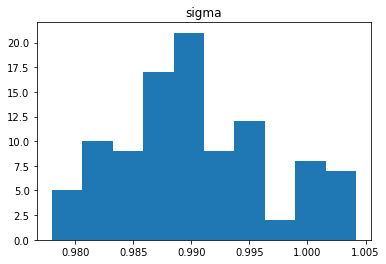

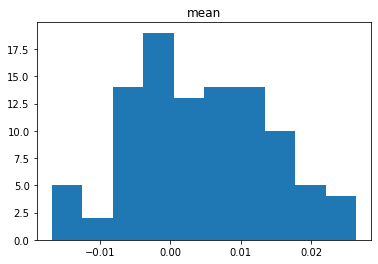

In [21]:
import pylab, numpy

xchain = engine.samples['sigma']
values = xchain[:,-1]  

pylab.figure()
pylab.title('sigma')
pylab.hist(engine.samples['sigma'][:,-1])

pylab.figure()
pylab.hist(engine.samples['mean'][:,-1])
pylab.title('mean')

###  Suggested Problem ###

Try changing the prior for this problem. How does it change the resulting distribution?

## 6. Estimating the distance of GW170817 ##

Now that we have some experience with models in pycbc inference, let's take a look at some of the existing models that pycbc inference provides targeted at gravitational-wave data analysis. We'll start with the `SingleTemplate` model. This model is useful when we know the intrinsic parameters of a source (i.e. component masses, spins), but we don't know the extrinsic parameters (i.e. sky location, distance, binary orientation). This will allow us to estimate the distance to GW170817 and the inclination of the orbital plan from our viewing angle. 

This model requires a specifc set of data products.
  * Dictionary of frequency-domain data (keyed by observatory short name such as 'H1', 'L1', 'V1').
  * Dictionary of power spectral density estimates
  * Low frequency cutoff to use for internal filtering in the model
  
We will make use of PyCBC gw signal processing tools to prepare this data.

In [22]:
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.frame import read_frame
from pycbc.filter import highpass, resample_to_delta_t
from astropy.utils.data import download_file

m = Merger("GW170817")

# List of observatories we'll analyze
ifos = ['H1', 
        'V1', 
        'L1',
       ]

# The single template waveform model needs these data products
psds = {}
data = {}

for ifo in ifos:
    print("Processing {} data".format(ifo))
    
    # Download the gravitational wave data for GW170817
    url = "https://dcc.ligo.org/public/0146/P1700349/001/{}-{}1_LOSC_CLN_4_V1-1187007040-2048.gwf"
    fname = download_file(url.format(ifo[0], ifo[0]), cache=True) 

    # Read the gravitational wave data and do some minimal
    # conditioning of the data.
    ts = read_frame(fname, "{}:LOSC-STRAIN".format(ifo),
                    start_time=int(m.time - 260),
                    end_time=int(m.time + 40))
    ts = highpass(ts, 15.0)                     # Remove low frequency content
    ts = resample_to_delta_t(ts, 1.0/2048)      # Resample data to 2048 Hz
    ts = ts.time_slice(m.time-112, m.time + 16) # Limit to times around the signal
    data[ifo] = ts.to_frequencyseries()         # Convert to a frequency series by taking the data's FFT

    # Estimate the power spectral density of the data
    psd = interpolate(ts.psd(4), ts.delta_f)
    psd = inverse_spectrum_truncation(psd, int(4 * psd.sample_rate), 
                                      trunc_method='hann',
                                      low_frequency_cutoff=20.0)
    psds[ifo] = psd


Processing H1 data
Processing V1 data
Processing L1 data


A number of parameters must also be provided as 'static' parameters. These include 
   * mass1 (Units in solar masses)
   * mass2 (Units in solar masses)
   * f_lower (used for where to start our gravitational waveform model generation from)
   * approximant (This sets which waveform model we are using)

If a model supports other intrinsic parameters (such as components spins), they may 
also optionally be provided.

There are also a fixed set of 'variable' parameters. These are the only ones which we
can obtain estimates of with this model. These are
   * ra        (Units in radians)
   * dec       (Units in radians)
   * distance  (Units in Megaparsecs)
   * inclination (Units in radians)
   * polarization (Units in radians)
   * tc           (Units in seconds): This parameter is roughly the time of merger.
   
It's important to note that anything which could be a variable paramater, can be transformed
into a static parameter by supplying a specific value for it. We take advantage of this below
to limit our analyis to only sample over 'distance', 'inclination', and 'tc'. We set the sky location
to the location of NGC 4993, the galaxy where an electromagnetic counterpart to GW170817 was observed.

In [23]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle
import numpy

static = {'mass1':1.3757,
          'mass2':1.3757,
          'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
          'ra': 3.44615914,
          'dec': -0.40808407
         }

variable = ('distance',
            'inclination',
            'tc')

prior = JointDistribution(variable,
                SinAngle(inclination=None), 
                Uniform(
                    distance=(10, 100),
                    tc=(m.time-.2, m.time+0.2),
                )
        )

We are not ready to create our SingleTemplate model instance. Note how the variable and static parameters
are passed to the model. This is a common way this information can be passed for built-in pycbc inference models.

Notice that we are no longer using the Emcee sampler. While Emcee is sufficient for many problems, EmceePT, a parallel tempered version of Emcee is more effective at most gravitational-wave data analysis problems. There is one additional parameter we need to give to EmcceePT which is the number of temperatures. The output of this sampler will thus be 3-dimensional (temps x walkers x iterations). The 'coldest' temperature (0) will contain our actual results. 

In [24]:
import copy
model = models.SingleTemplate(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':25, 'L1':25, 'V1':25},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )
smpl = sampler.EmceePTSampler(model, 3, 200, nprocesses=8)
_ = smpl.set_p0() # If we don't set p0, it will use the models prior to draw initial points!

In [25]:
# Note it may take ~1-3 minutes for this to run
smpl.run_mcmc(200)

In addition to the sampled parameters, we can also get the likelihood values our model produces. We don't go into it here, but it is also possible for models to make arbitary auxiliary information about each sample available.

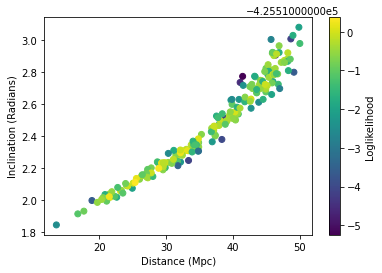

In [26]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Note how we have to access the arrays differently that before since there is an additional dimension. 
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
pylab.scatter(s['distance'][0,:,-1],
              s['inclination'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Distance (Mpc)')
pylab.ylabel('Inclination (Radians)')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

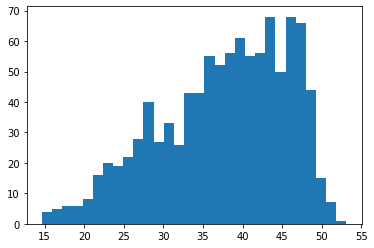

In [27]:
_ = pylab.hist(s['distance'][0,:,-100::20].flatten(), bins=30)

#### 6.1 Watch how the position of the walkers evolves in time ###

We can see how our ensemble of walkers evolves with time using the animation utilities of matplotlib. We haven't covered the concept of "burn-in" in this tutorial, however, if you watch the animation, you can see the point
that the distribution is effectively burned-in.

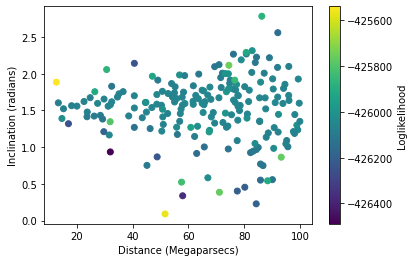

In [29]:
%matplotlib inline
from matplotlib import animation
import pylab

# We'll plot the initial position of the walkers
fig = pylab.figure(10)
a = pylab.scatter(s['distance'][0,:,0],
                  s['inclination'][0,:,0],
                  c=lik[0,:,0])
pylab.xlabel('Distance (Megaparsecs)')
pylab.ylabel('Inclination (radians)')
c = pylab.colorbar()
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = numpy.array([s['distance'][0,:,i], s['inclination'][0,:,i]])
    a.set_offsets(dat.T)
    a.set_array(lik[0,:,i])
    return (a, )
    
nsamples = len(s['distance'][0,0,:])
ani = animation.FuncAnimation(fig, animate, frames=nsamples,
                              interval=200, blit=True)

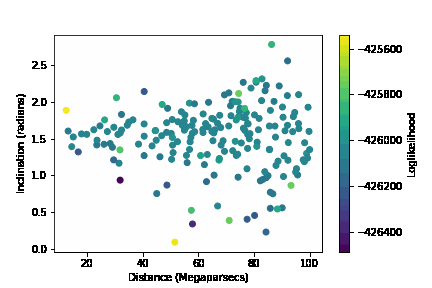

In [30]:
from matplotlib.animation import PillowWriter
from IPython.display import Image

# Note to get this to play, you may need to right click on the image and
# download to your computer or open the image in a new tab of your browser
ani.save('move.gif', writer=PillowWriter(fps=5))
with open('move.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

#  Suggested Problems ###

1. If we exclude Virgo and Livingston how is the recovery of distance and inclination affected? How about if we just exclude Virgo? Hint: you can do this by modifying the 'ifos' list of the first cell in this section. 
2. GW170817 was identified with a counterpart in NGC4993. If we use the distance to NG4993 as a prior (41 +-3 Mpc) can we improve our estimate of the source binary inclination? Try setting a Gaussian prior based on this additional information.
3. How well measured is the time of coalesence ('tc') ?
3. (For the curious) Try the EmceeSampler like we've used in previous examples. How do the results compare after the same number of iterations? Note, remember that the Emcee and EmceePT samplers don't have the same format sample chains. Ecmee uses a walker x iteration chain, while EmceePT will have a temp x walker x iteration format.


## 7. Estimating the sky location of GW170817 ##

We will now extend the previous example and also estimate the sky location of the source from the
gravitational-wave data alone

In [31]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution, SinAngle, UniformSky
import numpy

static = {'mass1':1.3757,
          'mass2':1.3757,
          'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
         }

variable = ('distance',
            'inclination',
            'tc',
            'ra',
            'dec',
            )
prior = JointDistribution(variable, 
                Uniform(
                    inclination=(2, numpy.pi),
                    distance=(20, 50),
                    tc=(m.time+.02, m.time+0.05),
                ),
                UniformSky(),   # This is a custom distribution which
                                # expects ra / dec and creates a isotropic distribution
        )

In [32]:
import copy
model = models.SingleTemplate(variable, copy.deepcopy(data),
                              low_frequency_cutoff={'H1':25, 'L1':25, 'V1':25},
                              psds = psds,
                              static_params = static,
                              prior = prior,
                              sample_rate = 8192,
                              )
smpl = sampler.EmceePTSampler(model, 3, 200, nprocesses=8)
_ = smpl.set_p0()

In [33]:
# Note it may take a few minutes for this to run
smpl.run_mcmc(200)

In addition to the sampled parameters, we can also get the likelihood values our model produces. We don't go into it here, but it is also possible for models to make arbitary auxiliary information about each sample available.

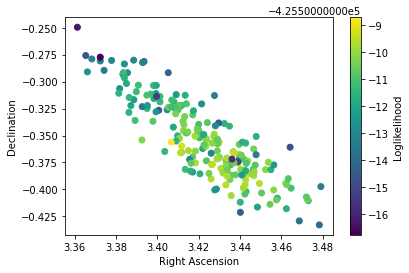

In [34]:
lik = smpl.model_stats['loglikelihood']
s = smpl.samples

# Note how we have to access the arrays differently that before since there is an additional dimension. 
# The zeroth element of that dimension represents the 'coldest' and is the one we want for our results.
# The other temperatures represent a modified form of the likelihood that allows walkers to traverse
# the space more freely.
pylab.scatter(s['ra'][0,:,-1],
              s['dec'][0,:,-1],
              c=lik[0,:,-1])
pylab.xlabel('Right Ascension')
pylab.ylabel('Declination')

c = pylab.colorbar()
c.set_label('Loglikelihood')
pylab.show()

#### 7.1 Watch how the position of the walkers evolves in time ###

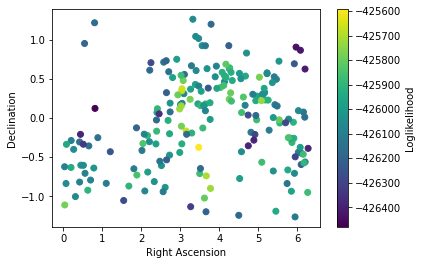

In [35]:
%matplotlib inline
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import Image
import pylab

# We'll plot the initial position of the walkers
fig = pylab.figure(11)
a = pylab.scatter(s['ra'][0,:,0],
                  s['dec'][0,:,0],
                  c=lik[0,:,0])
pylab.xlabel('Right Ascension')
pylab.ylabel('Declination')
c = pylab.colorbar()
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = numpy.array([s['ra'][0,:,i], s['dec'][0,:,i]])
    a.set_offsets(dat.T)
    a.set_array(lik[0,:,i])
    return (a, )
    
nsamples = len(s['ra'][0,0,:])
ani = animation.FuncAnimation(fig, animate, frames=nsamples,
                              interval=200, blit=True)

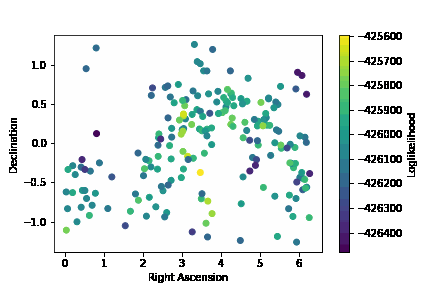

In [36]:
ani.save('move2.gif', writer=PillowWriter(fps=5))
with open('move2.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

#  Suggested Problems ###

1. Does our measured sky position agree with the location of the NGC 4993 galaxy? (note that the location is in a previous example). 
2. How is the sky location affected if we remove Virgo? 

## 8. Estimating the chirp mass of GW170817 ##

We'll now trying using a model which we commonly use to estimate the parameters of binary mergers, `MarginalizedPhaseGaussianNoise`. Unlike `SingleTemplate`, this model generates a new gravitational waveform for each set of parameters it tests. We'll use this to get a rough estimate of the chirp mass of GW170817. To help
speed this up to run in a notebook, we'll limit to two paramters, the time of arrival (tc),  chirp mass, and mass
ration (q). All other parameters we'll fix. We'll also place strict limits on mass ratio so it is essentially forced to be an equal mass system.

In [37]:
from pycbc.inference import models, sampler
from pycbc.distributions import Uniform, JointDistribution
import numpy

static = {'f_lower':25.0,
          'approximant':"TaylorF2",
          'polarization':0,
          'inclination':2.4,
          'ra': 3.44615914,
          'dec': -0.40808407,
          'distance':40,
          'f_final':500,
         }

variable = ('mchirp',
            'q',
            'tc',
            )
prior = JointDistribution(variable, 
                Uniform(
                    mchirp=(1.197, 1.198),
                    q=(1, 1.0001),
                    tc=(m.time+.02, m.time+0.05),
                ),
        )

The model here takes similar arguments to the SingleTemplate model. Note that we are providing a new argument, 'waveform_transforms'. Normally a merger signal is parameterized by its component masses, mass1 / mass2. We are going
to estimate the chirp mass and try to sample in chirp mass and mass ratio. We can do this by providing the
mapping between mchirp/q -> mass1/mass2. In this way we can use different parametizations than a model normally
supports. 

In [38]:
import copy
from pycbc.transforms import MchirpQToMass1Mass2

model = models.MarginalizedPhaseGaussianNoise(variable, data,
                                              low_frequency_cutoff = {'H1':25, 'L1':25, 'V1':25},
                                              high_frequency_cutoff = {'H1':500, 'L1':500, 'V1':500},
                                              psds = psds,
                                              static_params = static,
                                              prior = prior,
                                              waveform_transforms = [MchirpQToMass1Mass2()]
                                             )
smpl = sampler.EmceePTSampler(model, 2, 50, nprocesses=8)
_ = smpl.set_p0()

Note it may take a few minutes for this to run. If we were to run this all parameters enabled, this run would
normally take O(day) on a few dozen cores. That's where parallelization can really help! Thankfully, for
production runs pycbc inference supports single node multiprocessing and MPI. 

In [ ]:
smpl.run_mcmc(50)

#### 8.1 Walker Evolution

In [ ]:
%matplotlib inline
from matplotlib import animation
from matplotlib.animation import PillowWriter
from IPython.display import Image
import pylab

# We'll plot the initial position of the walkers
fig = pylab.figure(11)

s = smpl.samples
a = pylab.scatter(s['mchirp'][0,:,0],
                  s['tc'][0,:,0],
                 )
pylab.xlabel('Chirp Mass')
pylab.ylabel('Coalescence Time')
pylab.xlim(1.197, 1.198)
c.set_label('Loglikelihood')

# This function will update the plot with the ith iteration of our mcmc chain.
def animate(i):
    dat = numpy.array([s['mchirp'][0,:,i], s['tc'][0,:,i]])
    a.set_offsets(dat.T)
    return (a, )


nsamples = len(s['tc'][0,0,:])
print(s['tc'].shape)
print(nsamples)
ani = animation.FuncAnimation(fig, animate, frames=nsamples,
                              interval=200, blit=True)

In [ ]:
ani.save('move3.gif', writer=PillowWriter(fps=5))
with open('move3.gif','rb') as f:
    display(Image(data=f.read(), format='png'))